In [1]:
import matplotlib.pyplot as plt
import numpy as np
import h5py

## Part A

In [2]:
filename = 'assign2_data1.h5'

with h5py.File(filename, 'r') as f:
    # List all groups
    print("Keys: %s" % f.keys())
    # Get the data
    test_img = f[list(f.keys())[0]].value
    test_labels = f[list(f.keys())[1]].value
    train_img = f[list(f.keys())[2]].value
    train_labels = f[list(f.keys())[3]].value
test_labels = test_labels.reshape((len(test_labels),1))
train_labels = train_labels.reshape((len(train_labels),1))

Keys: <KeysViewHDF5 ['testims', 'testlbls', 'trainims', 'trainlbls']>


/home/ayhan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  import sys
/home/ayhan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:8: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  
/home/ayhan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:9: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  if __name__ == '__main__':
/home/ayhan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:10: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  # Remove the CWD from sys.path while we load stuff.


In [3]:
class Layer:
    def __init__(self, inputDim, numNeurons, std, beta=1, mean=0):
        self.inputDim = inputDim
        self.numNeurons = numNeurons
        
        self.beta = beta
        
        self.weights = np.random.normal(mean,std, inputDim*numNeurons).reshape(numNeurons, inputDim)
        self.biases = np.random.normal(mean,std, numNeurons).reshape(numNeurons,1)
        
        self.weightsE = np.concatenate((self.weights, self.biases), axis=1)
        
        self.delta = None
        self.error = None
        self.lastActiv = None
        
    def activtanh(self, x):
        if(x.ndim == 1):
            x = x.reshape(x.shape[0],1)
        numSamples = x.shape[1]
        tempInp = np.r_[x, [np.ones(numSamples)*-1]]
        self.lastActiv = np.tanh(self.beta*np.matmul(self.weightsE, tempInp))
        return self.lastActiv
    
    def tanhDer(self, x):
        return self.beta*(1-(x**2))
    
    def __repr__(self):
        return "Input Dim: " + str(self.inputDim) + ", Number of Neurons: " + str(self.numNeurons)

In [4]:
class MLP:
    def __init__(self):
        self.layers = []
        
    def addLayer(self, layer):
        self.layers.append(layer)
        
    def forward(self, inp):
        out = inp
        for lyr in self.layers:
            #print("input", inp.shape)
            out = lyr.activtanh(out)
            #print("output", inp.shape)
        return out
    
    #only for binary classificaiton with 1 output neurons
    def prediction(self, inp):
        out = self.forward(inp)
        out[out>=0] = 1
        out[out<0] = -1
        return out 
    
    def backProp(self, inp, out, lrnRate, batchSize):
            
        net_out = self.forward(inp)
        #print('network out: ', net_out.shape)

        for i in reversed(range(len(self.layers))):
            lyr = self.layers[i]
            
            #outputLayer
            if(lyr == self.layers[-1]):
                lyr.error = out - net_out
                '''print("out\n",out)
                print("net out\n", net_out)
                print("error = out - net_out\n", lyr.error)'''
                derMatrix = lyr.tanhDer(lyr.lastActiv)
                #print("derMatrix = dertanh-lastActiv-\n", derMatrix)
                lyr.delta = derMatrix * lyr.error
            #hiddenLayer
            else:
                nextLyr = self.layers[i+1]
                nextLyr.weights = nextLyr.weightsE[:,0:nextLyr.weights.shape[1]]
                lyr.error = np.matmul(nextLyr.weights.T, nextLyr.delta)
                #print("Error: \n", lyr.error)
                derMatrix = lyr.tanhDer(lyr.lastActiv)
                #print("derMatrix \n", derMatrix)
                lyr.delta = derMatrix * lyr.error
        
        #update weights
        for i in range(len(self.layers)):
            lyr = self.layers[i]
            #print(inp)
            if(i == 0):
                if(inp.ndim == 1):
                    inp = inp.reshape(inp.shape[0],1)
                numSamples = inp.shape[1]
                inputToUse = np.r_[inp, [np.ones(numSamples)*-1]]
            else:
                numSamples = self.layers[i - 1].lastActiv.shape[1]
                inputToUse = np.r_[self.layers[i - 1].lastActiv, [np.ones(numSamples)*-1]]
            lyr.weightsE += (lrnRate* np.matmul(lyr.delta, inputToUse.T))/batchSize
            '''print("Layer:", i)
            print("delta: \n", lyr.delta)
            print("inputTouse.T: \n", inputToUse.T)
            print("Product: \n", np.matmul(lyr.delta, inputToUse.T))
            print("Weights: \n", lyr.weightsE)'''
        
            
    def train(self, inp, out, inpTest, outTest, lrnRate, epochNum, batchSize):
        mseList = []
        mceList = []
        mseTList = []
        mceTList = []
        
        for ep in range(epochNum):
            print('Epoch', ep)
            
            randomIndexes = np.random.permutation(len(inp))
            inp = inp[randomIndexes]
            out = out[randomIndexes]
            
            numBatches = int(np.floor(len(inp)/batchSize))
            
            for j in range(numBatches):
                self.backProp(inp[batchSize*j:batchSize*j+batchSize].T, out[batchSize*j:batchSize*j+batchSize].T, lrnRate, batchSize)
                
            mse = np.mean((out.T - self.forward(inp.T))**2, axis=1)
            mseList.append(mse)
            mce = np.sum(self.prediction(inp.T) == out.T)/len(out)*100
            mceList.append(mce)
            mseT = np.mean((outTest.T - self.forward(inpTest.T))**2, axis=1)
            mseTList.append(mseT)
            mceT = np.sum(self.prediction(inpTest.T) == outTest.T)/len(outTest)*100
            mceTList.append(mceT)
        return mseList, mceList, mseTList, mceTList
    
    def __repr__(self):
        retStr = ""
        for i, lyr in enumerate(self.layers):
            retStr += "Layer " + str(i) + ": " + lyr.__repr__() + "\n"
        return retStr

In [5]:
print(test_img.shape,test_labels.shape)
print(train_img.shape, train_labels.shape)

inputWH = train_img.shape[1]

train_img_flat = train_img.reshape(train_img.shape[0], inputWH**2)
test_img_flat = test_img.reshape(test_img.shape[0], inputWH**2)

print(train_img_flat.shape, test_img_flat.shape)

(1000, 32, 32) (1000, 1)
(1900, 32, 32) (1900, 1)
(1900, 1024) (1000, 1024)


In [6]:
neuralNet = MLP()
neuralNet.addLayer(Layer(inputWH**2, 18, 0.02, 1))
neuralNet.addLayer(Layer(18, 1, 0.02, 1))

print(neuralNet)

train_labels[train_labels == 0] = -1

test_labels = test_labels.astype(int)
test_labels[test_labels == 0] = -1

#0.3 lr
#300 epoch
mses, mces, mseTs, mceTs = neuralNet.train(train_img_flat/255, train_labels, test_img_flat/255, test_labels, \
                                           0.35, 300, 38)

Layer 0: Input Dim: 1024, Number of Neurons: 18
Layer 1: Input Dim: 18, Number of Neurons: 1

Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25
Epoch 26
Epoch 27
Epoch 28
Epoch 29
Epoch 30
Epoch 31
Epoch 32
Epoch 33
Epoch 34
Epoch 35
Epoch 36
Epoch 37
Epoch 38
Epoch 39
Epoch 40
Epoch 41
Epoch 42
Epoch 43
Epoch 44
Epoch 45
Epoch 46
Epoch 47
Epoch 48
Epoch 49
Epoch 50
Epoch 51
Epoch 52
Epoch 53
Epoch 54
Epoch 55
Epoch 56
Epoch 57
Epoch 58
Epoch 59
Epoch 60
Epoch 61
Epoch 62
Epoch 63
Epoch 64
Epoch 65
Epoch 66
Epoch 67
Epoch 68
Epoch 69
Epoch 70
Epoch 71
Epoch 72
Epoch 73
Epoch 74
Epoch 75
Epoch 76
Epoch 77
Epoch 78
Epoch 79
Epoch 80
Epoch 81
Epoch 82
Epoch 83
Epoch 84
Epoch 85
Epoch 86
Epoch 87
Epoch 88
Epoch 89
Epoch 90
Epoch 91
Epoch 92
Epoch 93
Epoch 94
Epoch 95
Epoch 96
Epoch 97
Epoch 98
Epoch 99
Epoch 100
Epoch 

Test Accuracy: 81.39999999999999%


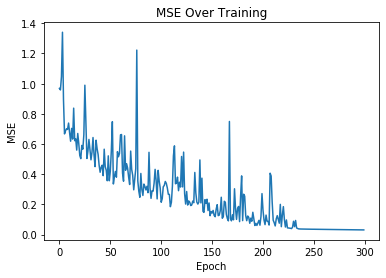

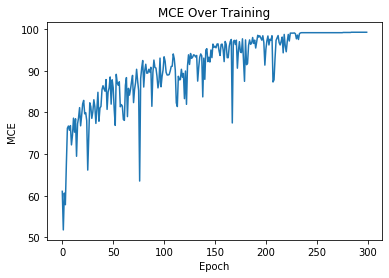

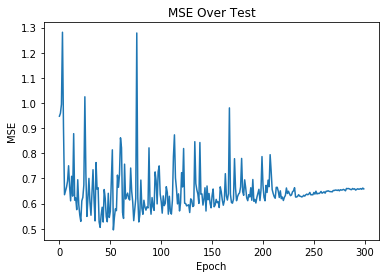

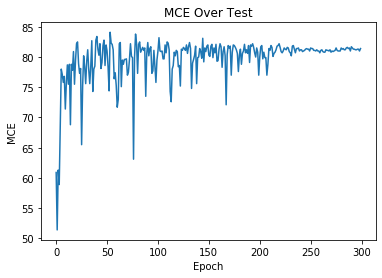

In [7]:
print("Test Accuracy:", str(np.sum(neuralNet.prediction(test_img_flat.T/255).T == test_labels)/len(test_labels)*100) + "%")

plt.plot(mses)
plt.title('MSE Over Training')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.show()

plt.plot(mces)
plt.title('MCE Over Training')
plt.xlabel('Epoch')
plt.ylabel('MCE')
plt.show()

plt.plot(mseTs)
plt.title('MSE Over Test')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.show()

plt.plot(mceTs)
plt.title('MCE Over Test')
plt.xlabel('Epoch')
plt.ylabel('MCE')
plt.show()

## Part C

In [8]:
neuralNetHigh = MLP()
neuralNetHigh.addLayer(Layer(inputWH**2, 800, 0.02, 1))
neuralNetHigh.addLayer(Layer(800, 1, 0.02, 1))
print(neuralNetHigh)

neuralNetLow = MLP()
neuralNetLow.addLayer(Layer(inputWH**2, 5, 0.02, 1))
neuralNetLow.addLayer(Layer(5, 1, 0.02, 1))
print(neuralNetLow)

msesH, mcesH, mseTsH, mceTsH = neuralNetHigh.train(train_img_flat/255, train_labels, test_img_flat/255, test_labels,\
                                                   0.35, 300, 38)
msesL, mcesL, mseTsL, mceTsL = neuralNetLow.train(train_img_flat/255, train_labels, test_img_flat/255, test_labels,\
                                                  0.35, 300, 38)

Layer 0: Input Dim: 1024, Number of Neurons: 800
Layer 1: Input Dim: 800, Number of Neurons: 1

Layer 0: Input Dim: 1024, Number of Neurons: 5
Layer 1: Input Dim: 5, Number of Neurons: 1

Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25
Epoch 26
Epoch 27
Epoch 28
Epoch 29
Epoch 30
Epoch 31
Epoch 32
Epoch 33
Epoch 34
Epoch 35
Epoch 36
Epoch 37
Epoch 38
Epoch 39
Epoch 40
Epoch 41
Epoch 42
Epoch 43
Epoch 44
Epoch 45
Epoch 46
Epoch 47
Epoch 48
Epoch 49
Epoch 50
Epoch 51
Epoch 52
Epoch 53
Epoch 54
Epoch 55
Epoch 56
Epoch 57
Epoch 58
Epoch 59
Epoch 60
Epoch 61
Epoch 62
Epoch 63
Epoch 64
Epoch 65
Epoch 66
Epoch 67
Epoch 68
Epoch 69
Epoch 70
Epoch 71
Epoch 72
Epoch 73
Epoch 74
Epoch 75
Epoch 76
Epoch 77
Epoch 78
Epoch 79
Epoch 80
Epoch 81
Epoch 82
Epoch 83
Epoch 84
Epoch 85
Epoch 86
Epoch 87
Epoch 88
Epoch 89
Epoch 90
Epo

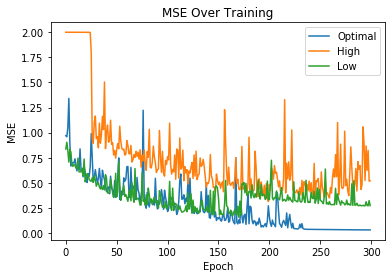

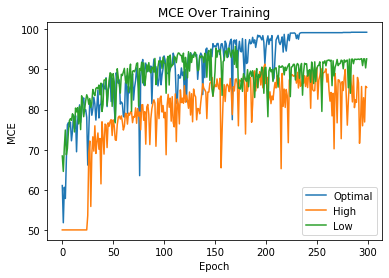

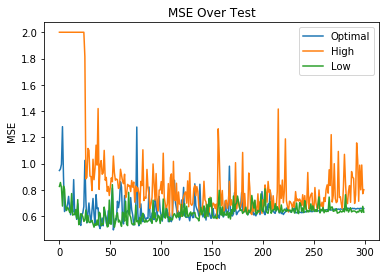

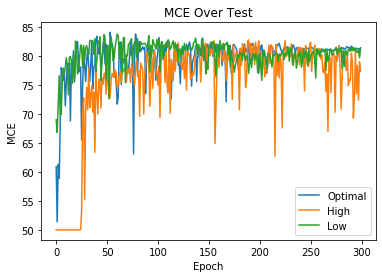

In [9]:
plt.plot(mses)
plt.plot(msesH)
plt.plot(msesL)
plt.title('MSE Over Training')
plt.legend(['Optimal', 'High', 'Low'])
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.show()

plt.plot(mces)
plt.plot(mcesH)
plt.plot(mcesL)
plt.title('MCE Over Training')
plt.legend(['Optimal', 'High', 'Low'])
plt.xlabel('Epoch')
plt.ylabel('MCE')
plt.show()

plt.plot(mseTs)
plt.plot(mseTsH)
plt.plot(mseTsL)
plt.title('MSE Over Test')
plt.legend(['Optimal', 'High', 'Low'])
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.show()

plt.plot(mceTs)
plt.plot(mceTsH)
plt.plot(mceTsL)
plt.title('MCE Over Test')
plt.legend(['Optimal', 'High', 'Low'])
plt.xlabel('Epoch')
plt.ylabel('MCE')
plt.show()

## Part D

In [10]:
neuralNetTwoHidden = MLP()
neuralNetTwoHidden.addLayer(Layer(inputWH**2, 450, 0.02, 1))
neuralNetTwoHidden.addLayer(Layer(450, 45, 0.02, 1))
neuralNetTwoHidden.addLayer(Layer(45, 1, 0.02, 1))

print(neuralNetTwoHidden)

mses2, mces2, mseTs2, mceTs2 = neuralNetTwoHidden.train(train_img_flat/255, train_labels,\
                                                        test_img_flat/255, test_labels,\
                                                        0.4, 260, 38)

Layer 0: Input Dim: 1024, Number of Neurons: 450
Layer 1: Input Dim: 450, Number of Neurons: 45
Layer 2: Input Dim: 45, Number of Neurons: 1

Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25
Epoch 26
Epoch 27
Epoch 28
Epoch 29
Epoch 30
Epoch 31
Epoch 32
Epoch 33
Epoch 34
Epoch 35
Epoch 36
Epoch 37
Epoch 38
Epoch 39
Epoch 40
Epoch 41
Epoch 42
Epoch 43
Epoch 44
Epoch 45
Epoch 46
Epoch 47
Epoch 48
Epoch 49
Epoch 50
Epoch 51
Epoch 52
Epoch 53
Epoch 54
Epoch 55
Epoch 56
Epoch 57
Epoch 58
Epoch 59
Epoch 60
Epoch 61
Epoch 62
Epoch 63
Epoch 64
Epoch 65
Epoch 66
Epoch 67
Epoch 68
Epoch 69
Epoch 70
Epoch 71
Epoch 72
Epoch 73
Epoch 74
Epoch 75
Epoch 76
Epoch 77
Epoch 78
Epoch 79
Epoch 80
Epoch 81
Epoch 82
Epoch 83
Epoch 84
Epoch 85
Epoch 86
Epoch 87
Epoch 88
Epoch 89
Epoch 90
Epoch 91
Epoch 92
Epoch 93
Epoch 94
Epoch 95
Epoc

Test Accuracy: 79.80000000000001%


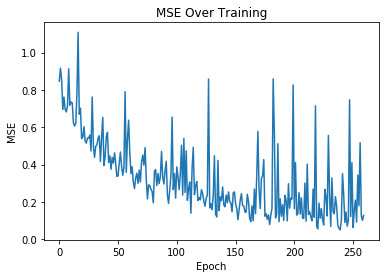

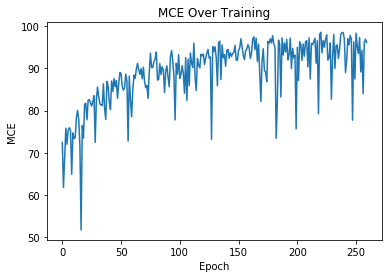

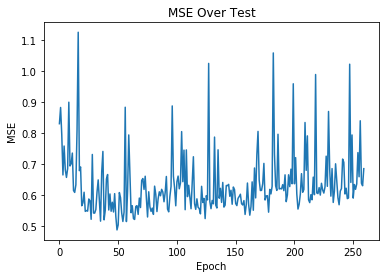

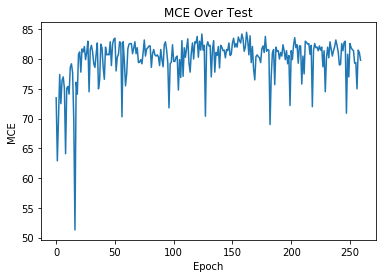

In [11]:
print("Test Accuracy:", str(np.sum(neuralNetTwoHidden.prediction(test_img_flat.T/255).T == test_labels)/len(test_labels)*100) + "%")

plt.plot(mses2)
plt.title('MSE Over Training')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.show()

plt.plot(mces2)
plt.title('MCE Over Training')
plt.xlabel('Epoch')
plt.ylabel('MCE')
plt.show()

plt.plot(mseTs2)
plt.title('MSE Over Test')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.show()

plt.plot(mceTs2)
plt.title('MCE Over Test')
plt.xlabel('Epoch')
plt.ylabel('MCE')
plt.show()

## Part E

In [12]:
class LayerwMom:
    def __init__(self, inputDim, numNeurons, std, mean=0):
        self.inputDim = inputDim
        self.numNeurons = numNeurons
        
        self.weights = np.random.normal(mean,std, inputDim*numNeurons).reshape(numNeurons, inputDim)
        self.biases = np.random.normal(mean,std, numNeurons).reshape(numNeurons,1)
        
        self.weightsE = np.concatenate((self.weights, self.biases), axis=1)
        
        self.delta = None
        self.error = None
        self.lastActiv = None
        
        self.prevUpdate = 0
        
    def activtanh(self, x):
        if(x.ndim == 1):
            x = x.reshape(x.shape[0],1)
        numSamples = x.shape[1]
        tempInp = np.r_[x, [np.ones(numSamples)*-1]]
        self.lastActiv = np.tanh(0.1*np.matmul(self.weightsE, tempInp))
        return self.lastActiv
    
    def tanhDer(self, x):
        return 0.1*(1-(x**2))
    
    def __repr__(self):
        return "Input Dim: " + str(self.inputDim) + ", Number of Neurons: " + str(self.numNeurons)

class MLPwMom:
    def __init__(self):
        self.layers = []
        
    def addLayer(self, layer):
        self.layers.append(layer)
        
    def forward(self, inp):
        out = inp
        for lyr in self.layers:
            #print("input", inp.shape)
            out = lyr.activtanh(out)
            #print("output", inp.shape)
        return out
    
    #only for binary classificaiton with 1 output neurons
    def prediction(self, inp):
        out = self.forward(inp)
        out[out>=0] = 1
        out[out<0] = -1
        return out 
    
    def backProp(self, inp, out, lrnRate, momCoeff, batchSize):
            
        net_out = self.forward(inp)
        #print('network out: ', net_out.shape)
        for i in reversed(range(len(self.layers))):
            lyr = self.layers[i]
            
            #outputLayer
            if(lyr == self.layers[-1]):
                lyr.error = out - net_out
                '''print("out\n",out)
                print("net out\n", net_out)
                print("error = out - net_out\n", lyr.error)'''
                derMatrix = lyr.tanhDer(lyr.lastActiv)
                #print("derMatrix = dertanh-lastActiv-\n", derMatrix)
                lyr.delta = derMatrix * lyr.error
            #hiddenLayer
            else:
                nextLyr = self.layers[i+1]
                nextLyr.weights = nextLyr.weightsE[:,0:nextLyr.weights.shape[1]]
                lyr.error = np.matmul(nextLyr.weights.T, nextLyr.delta)
                #print("Error: \n", lyr.error)
                derMatrix = lyr.tanhDer(lyr.lastActiv)
                #print("derMatrix \n", derMatrix)
                lyr.delta = derMatrix * lyr.error
        
        #update weights
        for i in range(len(self.layers)):
            lyr = self.layers[i]
            #print(inp)
            if(i == 0):
                if(inp.ndim == 1):
                    inp = inp.reshape(inp.shape[0],1)
                numSamples = inp.shape[1]
                inputToUse = np.r_[inp, [np.ones(numSamples)*-1]]
            else:
                numSamples = self.layers[i - 1].lastActiv.shape[1]
                inputToUse = np.r_[self.layers[i - 1].lastActiv, [np.ones(numSamples)*-1]]
            update =  lrnRate * np.matmul(lyr.delta, inputToUse.T)
            lyr.weightsE += update + momCoeff * lyr.prevUpdate
            lyr.prevUpdate = update
            '''print("Layer:", i)
            print("delta: \n", lyr.delta)
            print("inputTouse.T: \n", inputToUse.T)
            print("Product: \n", np.matmul(lyr.delta, inputToUse.T))
            print("Weights: \n", lyr.weightsE)'''
        
            
    def train(self, inp, out, inpTest, outTest, lrnRate, momCoeff, epochNum, batchSize):
        mseList = []
        mceList = []
        mseTList = []
        mceTList = []
        
        for ep in range(epochNum):
            print('Epoch', ep)
            
            randomIndexes = np.random.permutation(len(inp))
            inp = inp[randomIndexes]
            out = out[randomIndexes]
            
            numBatches = int(np.floor(len(inp)/batchSize))
            
            for j in range(numBatches):
                self.backProp(inp[batchSize*j:batchSize*j+batchSize].T, out[batchSize*j:batchSize*j+batchSize].T,\
                              lrnRate, momCoeff, batchSize)
                
            mse = np.mean((out.T - self.forward(inp.T))**2, axis=1)
            mseList.append(mse)
            mce = np.sum(self.prediction(inp.T) == out.T)/len(out)*100
            mceList.append(mce)
            mseT = np.mean((outTest.T - self.forward(inpTest.T))**2, axis=1)
            mseTList.append(mseT)
            mceT = np.sum(self.prediction(inpTest.T) == outTest.T)/len(outTest)*100
            mceTList.append(mceT)
        return mseList, mceList, mseTList, mceTList
    
    def __repr__(self):
        retStr = ""
        for i, lyr in enumerate(self.layers):
            retStr += "Layer " + str(i) + ": " + lyr.__repr__() + "\n"
        return retStr

In [13]:
neuralNetTwoHiddenM = MLPwMom()
neuralNetTwoHiddenM.addLayer(LayerwMom(inputWH**2, 450, 0.02))
neuralNetTwoHiddenM.addLayer(LayerwMom(450, 45, 0.02))
neuralNetTwoHiddenM.addLayer(LayerwMom(45, 1, 0.02))

print(neuralNetTwoHiddenM)  

momentum_coefficient = 0.1

mses2M, mces2M, mseTs2M, mceTs2M = neuralNetTwoHiddenM.train(train_img_flat/255, train_labels,\
                                                        test_img_flat/255, test_labels,\
                                                        0.4, momentum_coefficient, 260, 38)

Layer 0: Input Dim: 1024, Number of Neurons: 450
Layer 1: Input Dim: 450, Number of Neurons: 45
Layer 2: Input Dim: 45, Number of Neurons: 1

Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25
Epoch 26
Epoch 27
Epoch 28
Epoch 29
Epoch 30
Epoch 31
Epoch 32
Epoch 33
Epoch 34
Epoch 35
Epoch 36
Epoch 37
Epoch 38
Epoch 39
Epoch 40
Epoch 41
Epoch 42
Epoch 43
Epoch 44
Epoch 45
Epoch 46
Epoch 47
Epoch 48
Epoch 49
Epoch 50
Epoch 51
Epoch 52
Epoch 53
Epoch 54
Epoch 55
Epoch 56
Epoch 57
Epoch 58
Epoch 59
Epoch 60
Epoch 61
Epoch 62
Epoch 63
Epoch 64
Epoch 65
Epoch 66
Epoch 67
Epoch 68
Epoch 69
Epoch 70
Epoch 71
Epoch 72
Epoch 73
Epoch 74
Epoch 75
Epoch 76
Epoch 77
Epoch 78
Epoch 79
Epoch 80
Epoch 81
Epoch 82
Epoch 83
Epoch 84
Epoch 85
Epoch 86
Epoch 87
Epoch 88
Epoch 89
Epoch 90
Epoch 91
Epoch 92
Epoch 93
Epoch 94
Epoch 95
Epoc

Test Accuracy: 84.0%


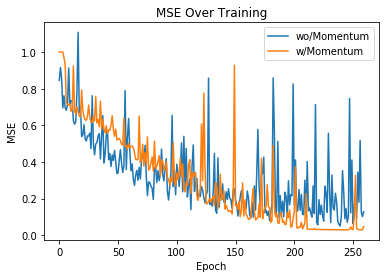

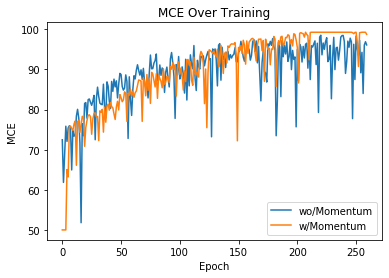

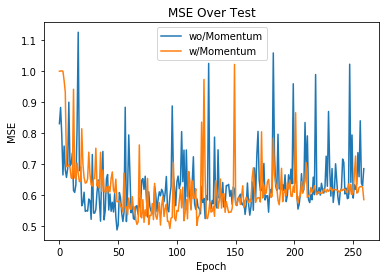

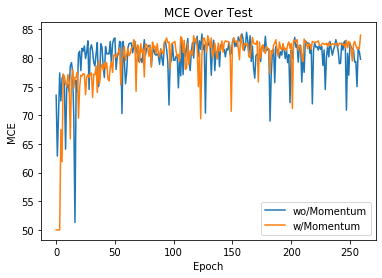

In [14]:
print("Test Accuracy:", str(np.sum(neuralNetTwoHiddenM.prediction(test_img_flat.T/255).T == test_labels)/len(test_labels)*100) + "%")

plt.plot(mses2)
plt.plot(mses2M)
plt.legend(['wo/Momentum','w/Momentum'])
plt.title('MSE Over Training')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.show()

plt.plot(mces2)
plt.plot(mces2M)
plt.legend(['wo/Momentum','w/Momentum'])
plt.title('MCE Over Training')
plt.xlabel('Epoch')
plt.ylabel('MCE')
plt.show()

plt.plot(mseTs2)
plt.plot(mseTs2M)
plt.legend(['wo/Momentum','w/Momentum'])
plt.title('MSE Over Test')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.show()

plt.plot(mceTs2)
plt.plot(mceTs2M)
plt.legend(['wo/Momentum','w/Momentum'])
plt.title('MCE Over Test')
plt.xlabel('Epoch')
plt.ylabel('MCE')
plt.show()